<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [1]:
!pip install xgboost

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row

sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "32g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne
from processing import split_by_col

from sparkxgb.xgboost import *

Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [3]:
DATA_PATH = '/home/stanislavv/data/criteo'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
DATA_PROCESSING_MODEL_CHECKPOINT = os.path.join(DATA_PATH, 'data_processing_model.bin')
LOGREG_MODEL_CHECKPOINT = os.path.join(DATA_PATH, 'logreg_model.bin')
XGB_MODEL_CHECKPOINT = os.path.join(DATA_PATH, 'xgb_model.bin')
PIPELINE2_MODEL_CHECKPOINT = os.path.join(DATA_PATH, 'pipeline2_model.bin')
XGB_MEANTARGET_MODEL_CHECKPOINT = os.path.join(DATA_PATH, 'xgb_meantarget_model.bin')

In [4]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [5]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [6]:
df = df.sample(False, 0.5)

In [7]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [8]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [9]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(DATA_PROCESSING_MODEL_CHECKPOINT)

In [10]:
pipeline_model.stages

[StringIndexer_d8ba7de945ab,
 StringIndexer_3c034b19a093,
 OneHotEncoderEstimator_6fcfa8584b36,
 VectorAssembler_e195545b597d]

In [11]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1389, 550)

Итоговая размерность пространства фичей

In [12]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

1952

In [13]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

1830136

In [14]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])

### Train

In [15]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [16]:
model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [17]:
model._call_java("booster").saveModel(XGB_MODEL_CHECKPOINT)

### Evaluation

In [18]:
baseline_metrics = {}

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [19]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    
    models = groups.keys()
    metrics = groups[control_name].keys()
    
    data = np.zeros((len(metrics), len(models)))
    for i, metric in enumerate(metrics):
        x_c = groups[control_name][metric]
        for j, model in enumerate(models):
            x_t = groups[model][metric]
            data[i, j] = (x_t - x_c) / x_c * 100
    
    return pd.DataFrame(data, columns=models, index=metrics)

In [20]:
rocauc(model, val_df, probabilities_col='probabilities')

0.7305500374850673

In [21]:
baseline_metrics['ROC AUC'] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics['ROC AUC']

0.7271812854797869

In [22]:
all_metrics['xgb_baseline'] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [23]:
from pyspark.ml.classification import LogisticRegressionModel
lr_model = LogisticRegressionModel.load(LOGREG_MODEL_CHECKPOINT)
all_metrics['logreg'] = {
    'ROC AUC': rocauc(lr_model, test_df, probabilities_col='probability')
}

Построить таблицу ATE используя метод `get_ate`

In [24]:
all_metrics

{'logreg': {'ROC AUC': 0.7006735746707738},
 'xgb_baseline': {'ROC AUC': 0.7271812854797869}}

In [25]:
get_ate(all_metrics, 'logreg')

,xgb_baseline,logreg
ROC AUC,3.783175,0.0


## New Model
### Prepare Data

In [26]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

df = df.fillna(0, subset=num_columns)

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [27]:
# Fitted Model
class MeanTargetEncoderModel(pyspark.ml.Model):
    def __init__(self, values, input_col, features_col):
        super().__init__()
        
        self.values = values
        self.input_col = input_col
        self.features_col = features_col
    
    def transform(self, df):
        return df \
            .join(self.values, on=self.input_col, how='left_outer') \
            .fillna(0, subset=[self.features_col])


# Estimator
class MeanTargetEncoder(pyspark.ml.Estimator):
    def __init__(self, input_col, target_col, features_col):
        super().__init__()
        
        self.input_col = input_col
        self.target_col = target_col
        self.features_col = features_col
    
    def fit(self, df):
        values = df \
            .groupby(self.input_col) \
            .agg(F.mean(self.target_col).alias(self.features_col))
        
        return MeanTargetEncoderModel(values, self.input_col, self.features_col)

#### Pipeline

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [29]:
pipeline_model = pipeline.fit(df)
# pipeline_model.save(PIPELINE2_MODEL_CHECKPOINT)

In [30]:
# from pyspark.ml import PipelineModel


# pipeline_model = PipelineModel.load(PIPELINE2_MODEL_CHECKPOINT)

In [31]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

3664584

### Train

Train XGBoost on the new set of features

In [32]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])
xgb_model = estimator.fit(train_df)
xgb_model._call_java('booster').saveModel(XGB_MEANTARGET_MODEL_CHECKPOINT)

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [33]:
all_metrics['xgb_meantarget'] = {
    'ROC AUC': rocauc(xgb_model, test_df, probabilities_col='probabilities')
}

In [34]:
get_ate(all_metrics, 'logreg')

,xgb_baseline,logreg,xgb_meantarget
ROC AUC,3.783175,0.0,4.779647


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [35]:
!pip install shap

In [36]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(XGB_MEANTARGET_MODEL_CHECKPOINT)

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


[11:56:55] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [37]:
print(bst.get_dump()[0])

0:[f10<1.99999905] yes=1,no=2,missing=1
	1:[f9<0.999998987] yes=3,no=4,missing=3
		3:[f14<0.282560438] yes=7,no=8,missing=7
			7:[f10<0.999998987] yes=15,no=16,missing=15
				15:[f12<1.99999905] yes=31,no=32,missing=31
					31:[f4<127866] yes=63,no=64,missing=64
						63:[f8<27.9999981] yes=127,no=128,missing=127
							127:[f14<0.209423214] yes=253,no=254,missing=253
								253:leaf=-0.217242882
								254:leaf=-0.184858859
							128:[f3<2.99999905] yes=255,no=256,missing=255
								255:leaf=-0.234472513
								256:leaf=-0.107142866
						64:[f3<1.99999905] yes=129,no=130,missing=129
							129:[f14<0.172221228] yes=257,no=258,missing=257
								257:leaf=-0.265772104
								258:leaf=-0.244091675
							130:[f14<0.245804697] yes=259,no=260,missing=260
								259:leaf=-0.16052632
								260:leaf=0.147457629
					32:[f14<0.159510225] yes=65,no=66,missing=65
						65:[f4<127866] yes=131,no=132,missing=132
							131:[f14<0.0995836779] yes=261,no=262,missing=261
								261:leaf=-

In [38]:
sample_df = df.sample(False, 0.05)
sample_df.count()

183519

In [39]:
from scipy.sparse import csr_matrix


def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    sparse_vecs = df.rdd.map(lambda row: row.features).collect()
    for i, vec in enumerate(sparse_vecs):
        for idx, val in enumerate(vec):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(sparse_vecs), dim))

In [40]:
%%time
X = df_to_csr(sample_df, 15)
dtest = xgb.DMatrix(X)

CPU times: user 7.3 s, sys: 163 ms, total: 7.46 s
Wall time: 8.69 s


In [41]:
X_arr = X.toarray()

In [42]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 6min 38s, sys: 129 ms, total: 6min 38s
Wall time: 25.8 s


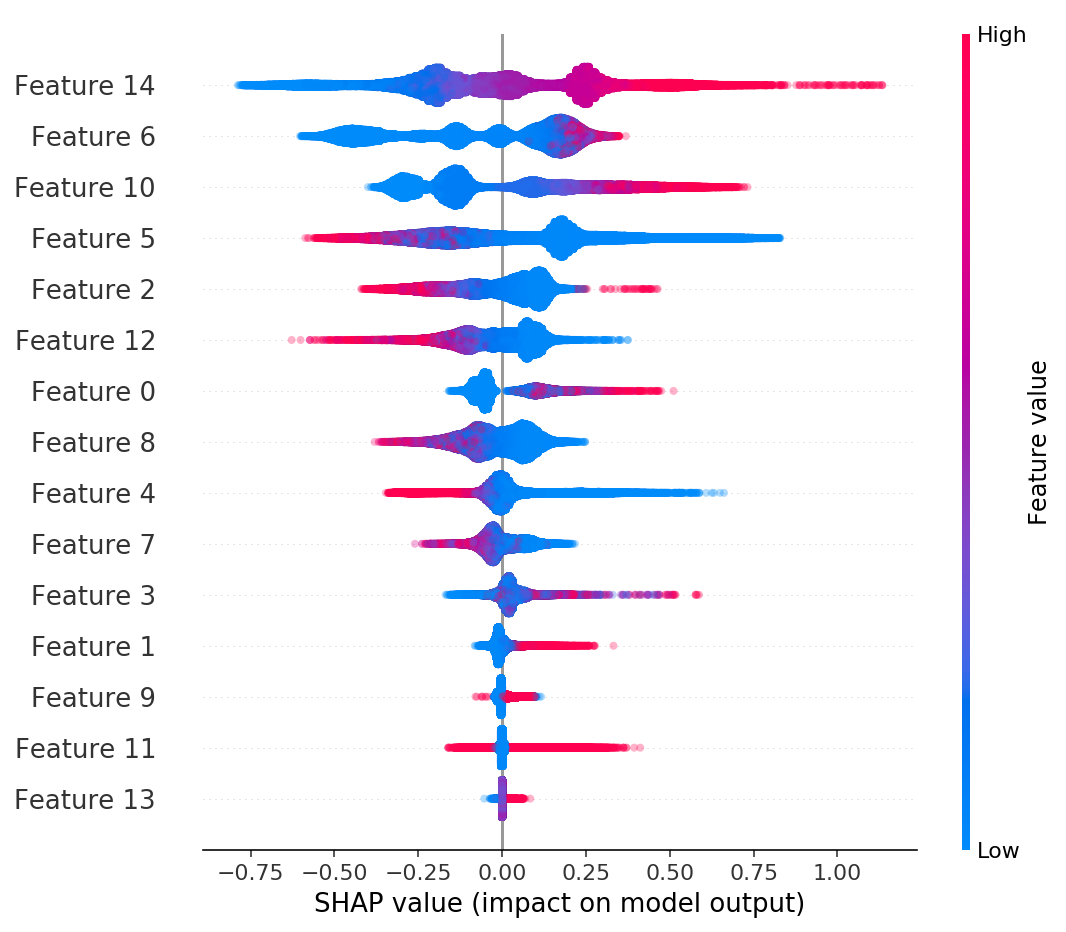

In [43]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [44]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [45]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

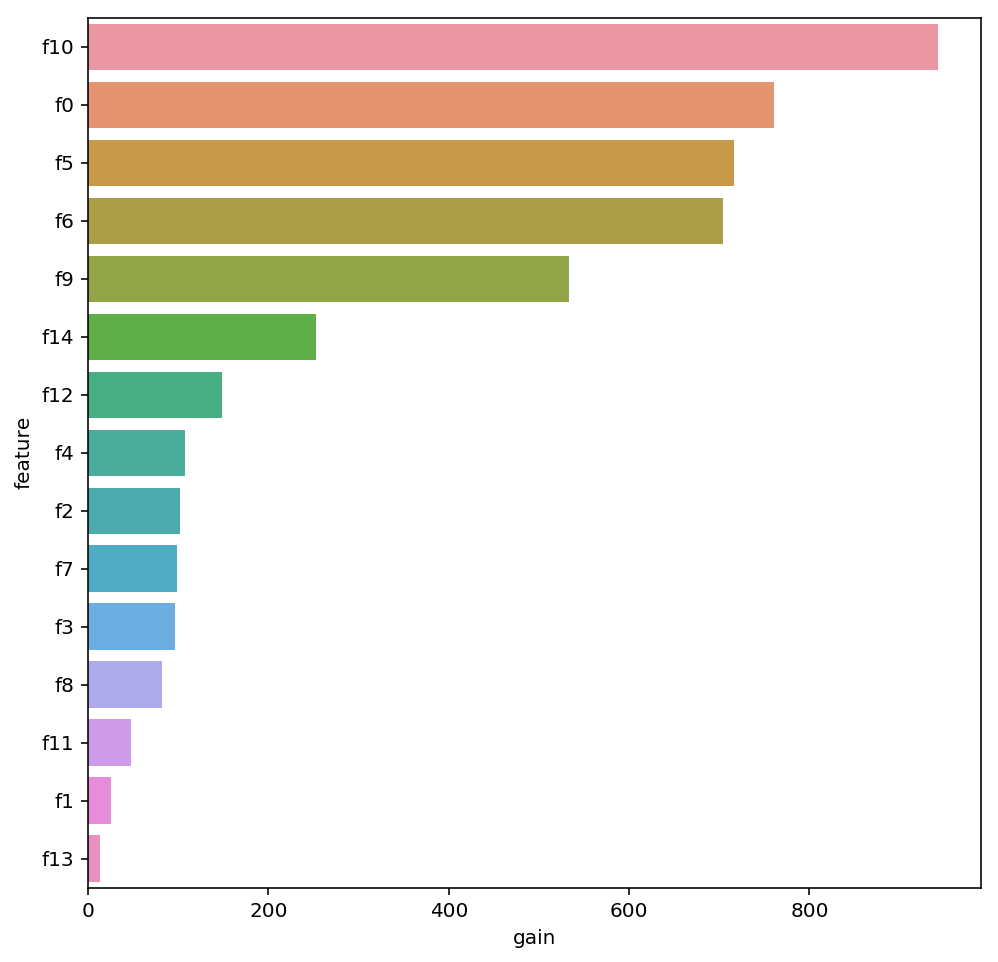

In [46]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [76]:
import pathlib
import xgboost
import argparse

from pyspark.sql import Window
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression


CP_BASE = pathlib.Path('xgb_logreg')
CP_BASE.mkdir(exist_ok=True)
CP = argparse.Namespace(
    xgb=CP_BASE / 'xbg.bin',
    pipe=CP_BASE / 'pipe.bin',
    lr=CP_BASE / 'lr.bin',
)
!ls $CP_BASE

lr.bin	pipe.bin  xbg.bin


In [80]:
class BaseMixin:
    tree_features = 'tree_features'
    
    def _xgb(self):
        return XGBoostEstimator(
            featuresCol=self.features,
            labelCol=self.label,
            predictionCol=self.prediction,
            colsample_bytree=0.9,
            eta=0.15,
            gamma=0.9,
            max_depth=8,
            min_child_weight=50.0,
            subsample=0.9,
            objective='binary:logistic',
            eval_metric='logloss', 
            silent=0,
            num_round=20,
            nthread=1,
            nworkers=1
        )
    
    def _leafs_df(self, xgb_model, df, add_label=True):
        leafs = xgb_model.predict(xgboost.DMatrix(df_to_csr(df, self.dim)), pred_leaf=True).tolist()
        
        if add_label:
            labels = [row[0] for row in df.select(self.label).collect()]
            data = [leaf + [label] for leaf, label in zip(leafs, labels)]
        else:
            data = leafs

        columns = ['leaf_{}'.format(i) for i in range(len(leafs[0]))]
        df_columns = columns + [self.label] if add_label else columns
        df = sqlContext.createDataFrame(data, df_columns)
        
        return df, columns
    
    def _concat_dfs(self, df1, df2):
        window = Window.orderBy(F.lit('A'))
        proxy_column = '_index'
        df1 = df1.withColumn(proxy_column, F.row_number().over(window))
        df2 = df2.withColumn(proxy_column, F.row_number().over(window))
        df = df1.join(df2, on=proxy_column).drop(proxy_column)
        return df
    
    def _pipe(self, columns, features):
        vec_columns = [c + '_vec' for c in columns]
        return Pipeline(stages=[
            OneHotEncoderEstimator(inputCols=columns, outputCols=vec_columns),
            VectorAssembler(inputCols=vec_columns, outputCol=features),
        ])
    
    def _lr(self, features):
        return LogisticRegression(
            featuresCol=features, 
            labelCol=self.label,
            predictionCol=self.prediction, 
            maxIter=10,
            regParam=0.0, 
            elasticNetParam=0.0
        )


class XgbLogRegModel(pyspark.ml.Model, BaseMixin):
    def __init__(self, dim=15):
        super().__init__()
        
        self.dim = dim
    
    def transform(self, df):
        # XGB
        xgb_model = xgboost.Booster()
        xgb_model.load_model(CP.xgb)
        leafs_df, columns = self._leafs_df(xgb_model, df, add_label=False)
        
        # Pipe
        pipe_model = PipelineModel.load(str(CP.pipe))
        leafs_df = pipe_model.transform(leafs_df).select(self.tree_features)
        df = self._concat_dfs(df, leafs_df)
        
        # LR
        lr_model = LogisticRegressionModel.load(str(CP.lr))
        output_df = lr_model.transform(df).drop(self.tree_features)
        
        return output_df


class XgbLogRegEstimator(pyspark.ml.Estimator, BaseMixin):
    def __init__(self, features='features', label='label', prediction='prediction', dim=15):
        super().__init__()
        
        self.features = features
        self.label = label
        self.prediction = prediction
        self.dim = dim
    
    def fit(self, df):
        # XGB
        xgb = self._xgb()
        xgb.fit(df)._call_java('booster').saveModel(str(CP.xgb))
        xgb_model = xgboost.Booster()
        xgb_model.load_model(CP.xgb)
        df, columns = self._leafs_df(xgb_model, df)
        
        # Pipe
        pipe = self._pipe(columns, self.tree_features)
        pipe_model = pipe.fit(df)
        pipe_model.write().overwrite().save(str(CP.pipe))
        df = pipe_model.transform(df).select(self.tree_features, self.label)
        
        # LR
        lr = self._lr(self.tree_features)
        lr.fit(df).write().overwrite().save(str(CP.lr))
        
        return XgbLogRegModel(dim=self.dim)

## Train

In [81]:
est = XgbLogRegEstimator()
model = est.fit(train_df)
model

[16:38:44] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


XgbLogRegModel_9c751c9b03ab

## Evaluation

In [ ]:
# def calibration(model, df):
#     ######################################
#     ######### YOUR CODE HERE #############
#     ######################################
#     pass

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [82]:
all_metrics['xgb_logreg'] = {
    'ROC AUC': rocauc(model, test_df, probabilities_col='probability')
}

[16:52:36] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


In [83]:
get_ate(all_metrics, 'logreg')

,xgb_baseline,logreg,xgb_meantarget,xgb_logreg
ROC AUC,3.783175,0.0,4.779647,4.806301


### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.